In [1]:
import os
import numpy as np
import tensorflow as tf
import h5py
import pandas as pd
import re
import gc
import matplotlib.pyplot as plt
import pickle

from keras.layers.normalization import BatchNormalization
from keras.models import Sequential,Model,load_model
from keras.layers import Flatten, Dense, Dropout, Lambda,Input,Activation
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.layers.pooling import GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import inception_v3
from keras.preprocessing import image
from keras import regularizers
from keras.utils import to_categorical
from keras.callbacks import Callback

Using TensorFlow backend.


In [2]:
DATA_DIR = "../data"
TRAIN_DIR = os.path.join(DATA_DIR,"train_2")
TEST_DIR = os.path.join(DATA_DIR,"test")

In [3]:
class InceptionV3:
    
    weights_path = "../saved_weights"
    models_path = "../saved_models"
    input_shape = (299,299,3)
    
    def __init__(self, num_classes=2,pretrained=True,
                 drop_rate=0.25,weight_decay=0):
        self.num_classes = num_classes
        self.drop_rate = drop_rate
        self.weight_decay = weight_decay
        self.cls_model = None
        self.pretrained = pretrained
       
        input_tensor = Input(InceptionV3.input_shape)
        x = Lambda(inception_v3.preprocess_input)(input_tensor)
        if self.pretrained:
            self.backend = inception_v3.InceptionV3(weights='imagenet', 
                                                       include_top=False, input_tensor=x)
        else:
            self.backend = inception_v3.InceptionV3(weights=None,
                                                      include_top=False,input_tensor=x)
            
        if not os.path.exists(InceptionV3.weights_path):
            os.mkdir(InceptionV3.weights_path)
        if not os.path.exists(InceptionV3.models_path):
            os.mkdir(InceptionV3.models_path)
        
    def preprocess(self,img):
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = inception_v3.preprocess_input(x)
        return x
    
    def build(self, fine_tune=True,layer_to_freeze=281, lr=0.001):
        self.base_model = Model(input=self.backend.input, output=GlobalAveragePooling2D()(self.backend.output))
        
        self.cls_model = Sequential()
        self.cls_model.add(Dropout(0.5,input_shape=self.base_model.output.shape.as_list()[1:]))
        self.cls_model.add(Dense(self.num_classes, activation='softmax',kernel_regularizer=regularizers.l2(self.weight_decay)))

        if fine_tune:
            for i,layer in enumerate(self.base_model.layers):
                if i<layer_to_freeze:
                    layer.trainable = False
                
        self.cls_model_compile(lr)
        
    def cls_model_compile(self,lr=0.001):
        self.cls_model.compile(optimizer=Adam(lr=lr),
                loss='categorical_crossentropy', metrics=['accuracy'])
    
   
    def save_weights(self,train_dir, test_dir, batch_size=32):
        gen = ImageDataGenerator()
        train_generator = gen.flow_from_directory(train_dir, (InceptionV3.input_shape[0],InceptionV3.input_shape[1]), 
                                                  shuffle=False, batch_size=batch_size)
        
        test_generator = gen.flow_from_directory(test_dir, (InceptionV3.input_shape[0],InceptionV3.input_shape[1]),
                                               shuffle=False, batch_size=batch_size,classes=None,class_mode=None)
        X_train =self.backend.predict_generator(train_generator, 
                                                   steps=(train_generator.samples)//batch_size,verbose=1)
        X_test = self.backend.predict_generator(test_generator, 
                                                   steps=(test_generator.samples)//batch_size,verbose=1)
        with h5py.File(os.path.join(InceptionV3.weights_path,"inception_v3.hdf5")) as f:
            f.create_dataset("train", data=X_train)
            f.create_dataset("test", data=X_test)
            f.create_dataset("label", data=train_generator.classes)
            
    @staticmethod
    def load_weights():
        X_train = []
        X_test = []
        y_train = []
        with h5py.File(os.path.join(InceptionV3.weights_path,"inception_v3.hdf5"), 'r') as fp:
            X_train.append(np.array(fp['train']))
            X_test.append(np.array(fp['test']))
            y_train = np.array(fp['label'])
        X_train = np.concatenate(X_train, axis=1) 
        X_test = np.concatenate(X_test, axis=1)
        return (X_train, y_train), X_test
        
    def fit(self, X_train,y_train,batch_size=32, epochs=10, validation_split=0.2):
        val_record = []
        history = self.cls_model.fit(X_train, y_train, batch_size=batch_size,
                      epochs=epochs, validation_split=validation_split,verbose=2)
        return history
        
    def test(self, X_test):
        gen = ImageDataGenerator()
        test_generator = gen.flow_from_directory(test_dir,(InceptionV3.input_shape[0],InceptionV3.input_shape[1]),
                                                 shuffle=False, batch_size=16)
        return self.cls_model.predict_generator(test_gen), self.test_generator.filenames
    
    def save_model(self, save_name):
        self.cls_model.save(os.path.join(self.models_path,save_name))
    
    def load_model(self, base_model_path, model_path):
        self.base_model = loads_model(base_model_path)
        self.cls_model = load_model(model_path)

In [ ]:
# Run on AWS p2.xlarge
model = InceptionV3()
model.save_weights(TRAIN_DIR, TEST_DIR,batch_size=2)

Found 24922 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.
  873/12461 [=>............................] - ETA: 962s  

In [4]:
(X_train,y_train),(X_test) = InceptionV3.load_weights()
y_train = to_categorical(y_train,2)
print(X_train.shape,y_train.shape)

(24922, 2048) (24922, 2)


In [5]:
drop_rate_set = [0.25, 0.5, 0.75]
weight_decay_set = [1e-4, 1e-3]
val_loss_records = []
val_acc_records = []
train_loss_records = []

i = 1
for drop_rate in drop_rate_set:
    for weight_decay in weight_decay_set:
        model = InceptionV3(num_classes=2, pretrained=True,
                 drop_rate=drop_rate,weight_decay=weight_decay)
        model.build(fine_tune=True, layer_to_freeze=313, lr=1e-4)
        history = model.fit(X_train, y_train, batch_size=64, epochs=20, validation_split=0.2)
        model.save_model("model_"+str(i)+".hdf5")
        i += 1
        val_loss_records.append(history.history['val_loss'])
        val_acc_records.append(history.history['val_acc'])
        train_loss_records.append(history.history['loss'])
        
        del model
        gc.collect()
        


C:\Users\11207\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel\__main__.py:36: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("gl...)`


Train on 19937 samples, validate on 4985 samples
Epoch 1/20
2s - loss: 0.3031 - acc: 0.8774 - val_loss: 0.1414 - val_acc: 0.9942
Epoch 2/20
1s - loss: 0.0857 - acc: 0.9841 - val_loss: 0.0671 - val_acc: 0.9974
Epoch 3/20
1s - loss: 0.0551 - acc: 0.9887 - val_loss: 0.0481 - val_acc: 0.9968
Epoch 4/20
1s - loss: 0.0405 - acc: 0.9909 - val_loss: 0.0405 - val_acc: 0.9958
Epoch 5/20
1s - loss: 0.0348 - acc: 0.9917 - val_loss: 0.0358 - val_acc: 0.9956
Epoch 6/20
1s - loss: 0.0310 - acc: 0.9923 - val_loss: 0.0269 - val_acc: 0.9962
Epoch 7/20
1s - loss: 0.0282 - acc: 0.9932 - val_loss: 0.0293 - val_acc: 0.9958
Epoch 8/20
1s - loss: 0.0261 - acc: 0.9931 - val_loss: 0.0232 - val_acc: 0.9962
Epoch 9/20
1s - loss: 0.0242 - acc: 0.9936 - val_loss: 0.0231 - val_acc: 0.9958
Epoch 10/20
1s - loss: 0.0229 - acc: 0.9940 - val_loss: 0.0220 - val_acc: 0.9958
Epoch 11/20
1s - loss: 0.0204 - acc: 0.9938 - val_loss: 0.0188 - val_acc: 0.9960
Epoch 12/20
1s - loss: 0.0205 - acc: 0.9946 - val_loss: 0.0234 - val_

In [6]:
model = InceptionV3(num_classes=2, pretrained=True,
                 drop_rate=1.0,weight_decay=0.0)
model.build(fine_tune=True, layer_to_freeze=313, lr=1e-4)
history = model.fit(X_train, y_train, batch_size=64, epochs=20, validation_split=0.2)
model.save_model("model_0.hdf5")



C:\Users\11207\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel\__main__.py:36: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("gl...)`


Train on 19937 samples, validate on 4985 samples
Epoch 1/20
4s - loss: 0.2505 - acc: 0.9053 - val_loss: 0.1247 - val_acc: 0.9916
Epoch 2/20
2s - loss: 0.0748 - acc: 0.9845 - val_loss: 0.0627 - val_acc: 0.9966
Epoch 3/20
2s - loss: 0.0497 - acc: 0.9893 - val_loss: 0.0418 - val_acc: 0.9968
Epoch 4/20
2s - loss: 0.0390 - acc: 0.9904 - val_loss: 0.0350 - val_acc: 0.9968
Epoch 5/20
2s - loss: 0.0315 - acc: 0.9920 - val_loss: 0.0275 - val_acc: 0.9970
Epoch 6/20
2s - loss: 0.0296 - acc: 0.9922 - val_loss: 0.0270 - val_acc: 0.9964
Epoch 7/20
2s - loss: 0.0255 - acc: 0.9936 - val_loss: 0.0262 - val_acc: 0.9956
Epoch 8/20
2s - loss: 0.0252 - acc: 0.9929 - val_loss: 0.0238 - val_acc: 0.9958
Epoch 9/20
2s - loss: 0.0231 - acc: 0.9931 - val_loss: 0.0199 - val_acc: 0.9962
Epoch 10/20
2s - loss: 0.0226 - acc: 0.9934 - val_loss: 0.0173 - val_acc: 0.9964
Epoch 11/20
2s - loss: 0.0216 - acc: 0.9938 - val_loss: 0.0247 - val_acc: 0.9944
Epoch 12/20
2s - loss: 0.0193 - acc: 0.9945 - val_loss: 0.0190 - val_

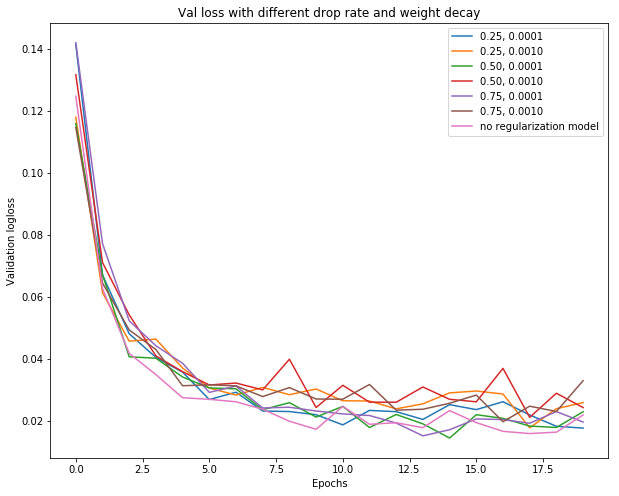

In [7]:
plt.figure(figsize=(10,8))
for i in range(len(val_loss_records)):
    plt.plot(val_loss_records[i],
             label=("%.2f, %.4f"%(drop_rate_set[i//2],weight_decay_set[i%2])))

plt.plot(history.history['val_loss'], label=("no regularization model"))

plt.title("Val loss with different drop rate and weight decay")
plt.xlabel("Epochs")
plt.ylabel("Validation logloss")
plt.legend()
plt.show()

In [8]:
best_model = load_model(os.path.join("../saved_models","model_1.hdf5"))

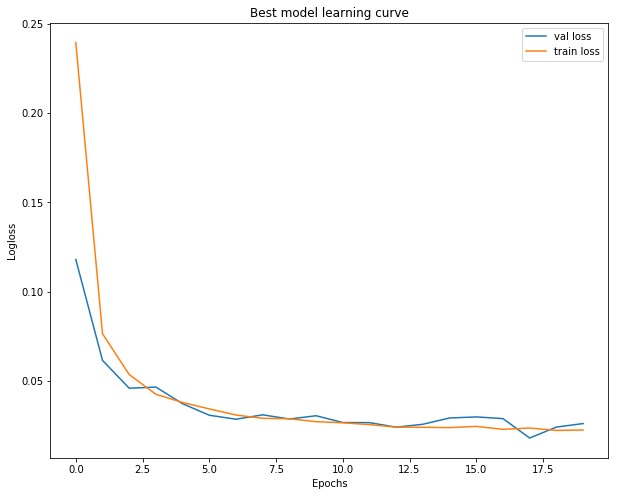

In [9]:
plt.figure(figsize=(10,8))
plt.plot(val_loss_records[1],label="val loss")
plt.plot(train_loss_records[1],label="train loss")
plt.xlabel("Epochs")
plt.ylabel("Logloss")
plt.legend()
plt.title("Best model learning curve")
plt.show()

In [11]:
y_pred = best_model.predict(X_test,verbose=1)
y_pred = y_pred.clip(min=0.0005,max=0.9995)

f = open("../filenames.pkl",'rb')
filenames = pickle.load(f)
f.close()

df = pd.DataFrame(index=[i for i in range(len(y_pred))],columns=['id','label'])
for i in range(len(y_pred)):
    index = int(re.search(r'\d+', filenames[i]).group())
    df.at[i,'id'] = index
    df.at[i,'label'] = y_pred[i][1]
df.to_csv("submission1.csv",index=False)

12288/12500 [============================>.] - ETA: 0s

In [12]:
df.head()

,id,label
0,11799,0.98721
1,12324,0.847108
2,5823,0.0005
3,10985,0.99871
4,8370,0.00704274
